In [1]:
import os
from pathlib import Path
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{u'kaggle.json': '{"username":"vijayravichandran06","key":"59262154c42f2b1fb7274cc755bc5beb"}'}

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [9]:
!kaggle competitions download -c denoising-dirty-documents

 79% 5.00M/6.30M [00:00<00:00, 31.8MB/s]
100% 6.30M/6.30M [00:00<00:00, 30.4MB/s]
 53% 5.00M/9.39M [00:00<00:00, 30.5MB/s]
100% 9.39M/9.39M [00:00<00:00, 45.9MB/s]
 63% 17.0M/27.1M [00:00<00:00, 36.2MB/s]
100% 27.1M/27.1M [00:00<00:00, 61.1MB/s]
 86% 16.0M/18.5M [00:00<00:00, 39.5MB/s]
100% 18.5M/18.5M [00:00<00:00, 61.1MB/s]


In [11]:
!pwd

/content


In [12]:
!ls

kaggle.json  sampleSubmission.csv.zip  train_cleaned.zip
sample_data  test.zip		       train.zip


In [0]:
!unzip test.zip  

In [0]:
!unzip train.zip 

In [0]:
!unzip train_cleaned.zip

In [18]:
!ls

kaggle.json  sampleSubmission.csv.zip  train	      train_cleaned.zip
sample_data  test.zip		       train_cleaned  train.zip


('Total number of images in the training set: ', 144)
('Total number of cleaned images found: ', 144)
('Total number of samples in the test set: ', 72)


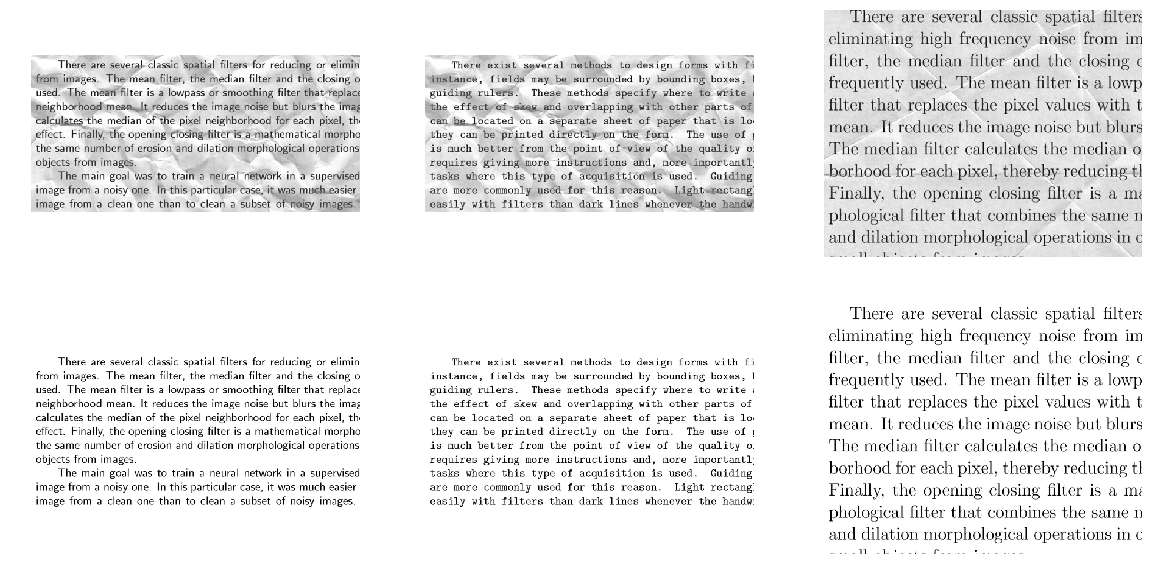

In [20]:


import glob
train_images = glob.glob('/content/train/*.png')
train_labels = glob.glob('/content/train_cleaned/*.png')
test_images = glob.glob('/content/test/*.png')

print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

# Lets' plot a few samples
# First row will be raw data, second row will be the corresponding cleaned images
samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img = imread(img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()    



In [0]:
def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
   
    #decoder

    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = UpSampling2D((2,2), name='upsample3')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv3')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='Adagrad', loss='binary_crossentropy')
    return autoencoder

In [22]:
autoencoder = build_autoenocder()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 420, 540, 1)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 32)      9248      
_________________________________________________________________
upsample3 (UpSampling2D)     (None, 420, 540, 32)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 420, 540, 1)       289       
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


In [23]:
X = []
Y = []

for img in train_images:
    img = load_img(img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

('Size of X : ', (144, 420, 540, 1))
('Size of Y : ', (144, 420, 540, 1))


In [24]:
# Split the dataset into training and validation.
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

('Total number of training samples: ', (129, 420, 540, 1))
('Total number of validation samples: ', (15, 420, 540, 1))


In [25]:
autoencoder.fit(X_train, y_train, epochs=30, batch_size=8, validation_data=(X_valid, y_valid))

Train on 129 samples, validate on 15 samples
Epoch 1/30
129/129 [==============================] - 98s 759ms/step - loss: 0.3451 - val_loss: 0.2788
Epoch 2/30
129/129 [==============================] - 95s 734ms/step - loss: 0.2476 - val_loss: 0.2278
Epoch 3/30
129/129 [==============================] - 95s 735ms/step - loss: 0.2114 - val_loss: 0.2137
Epoch 4/30
129/129 [==============================] - 95s 739ms/step - loss: 0.1739 - val_loss: 0.1888
Epoch 5/30
129/129 [==============================] - 94s 732ms/step - loss: 0.1600 - val_loss: 0.1604
Epoch 6/30
129/129 [==============================] - 95s 734ms/step - loss: 0.1523 - val_loss: 0.1677
Epoch 7/30
129/129 [==============================] - 95s 739ms/step - loss: 0.1466 - val_loss: 0.1576
Epoch 8/30
129/129 [==============================] - 95s 734ms/step - loss: 0.1429 - val_loss: 0.1453
Epoch 9/30
129/129 [==============================] - 95s 735ms/step - loss: 0.1388 - val_loss: 0.1437
Epoch 10/30
129/129 [=======

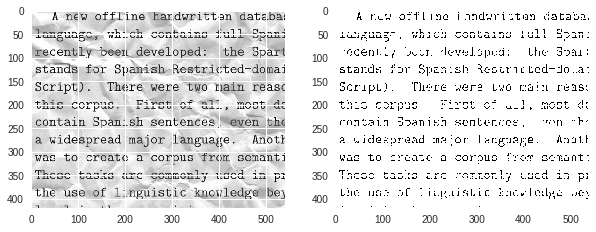

In [26]:
sample_test = load_img(test_images[10], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()